In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
import os
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from xgboost import XGBClassifier

# A Basic Exploration of Audio Data's Features
## (useful terms and their definitions)
### Tempo
Tempo is a measurement of the speed of musical compositions, normally denoted using beats per minute (BPM).

### Harmonics
Integers of the fundamental frequency. For example, the first harmonic is the lowest frequency. If we consider a plucked string, the first harmonic can be visualized as a standing wave which has a node at either end.

![harmonic_visualization](https://tghsl3physics.weebly.com/uploads/1/5/4/8/15482154/2803764.jpg?1424074599)[Figure 1](http://tghsl3physics.weebly.com/standing-waves.html)

### Spectral Centroid

Also known as center of spectral mass. The spectral centroid is a measure of the center of mass on a spectrum, and it provides insight into the brightness of a sound.

### Spectral Rolloff

The spectral rolloff point is the measured point where a percentage of the spectrum's total energy is contained below it. Typical percentages are between 85% and 95%. A lower rolloff point can indicate lower frequencies (and more bass), and a higher rolloff point can indicate higher frequencies (and more treble).[[1]](https://musicinformationretrieval.com/spectral_features.html#:~:text=Spectral%20rolloff%20is%20the%20frequency,%2C%20e.g.%2085%25%2C%20lies.)

### Mel Frequency Cepstral Coefficients (MFCCs)
MFCCs are useful in providing context based on human hearing, and in representing timbre (tone quality). The Mel Scale is based off the way humans perceive sound. The first step to developing an MFCC is converting frequency from Hertz to the Mel Scale. The log of the Mel converted frequencies is taken, and a discrete cosine transformation is used on the log's magnitude. This gives us MFCCs in the form of a spectrogram over the Mel frequencies (rather than over time).[[2]](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8)

### Zero Crossing Rate (ZCR)
ZCR is the number of times a signal transitions over zero. So the rate at which it goes from positive, to zero, to negative, or vice versa. ZCR is an indicator for noise: a higher ZCR indicates a noisier signal. [[3]](https://www.sciencedirect.com/topics/engineering/zero-crossing-rate)


### Chroma Frequencies
In western music, the musical octave has 12 distinct semitones (chroma). Analysis of chroma frequencies provides us with a visual representation based on musical notes (disregarding octave), which can help find similarities in audio. A chromogram represents the intensity of each chroma over time. [[4]](https://ee.columbia.edu/~dpwe/resources/matlab/chroma-ansyn/)

# Exploratory Data Analysis (EDA)
This will be an analysis and visual exploration of the GTZAN dataset. In data science, EDA helps in discovering patterns or relationships within the data, as well as identifying errors or outlying data. [[5]](https://www.ibm.com/topics/exploratory-data-analysis)

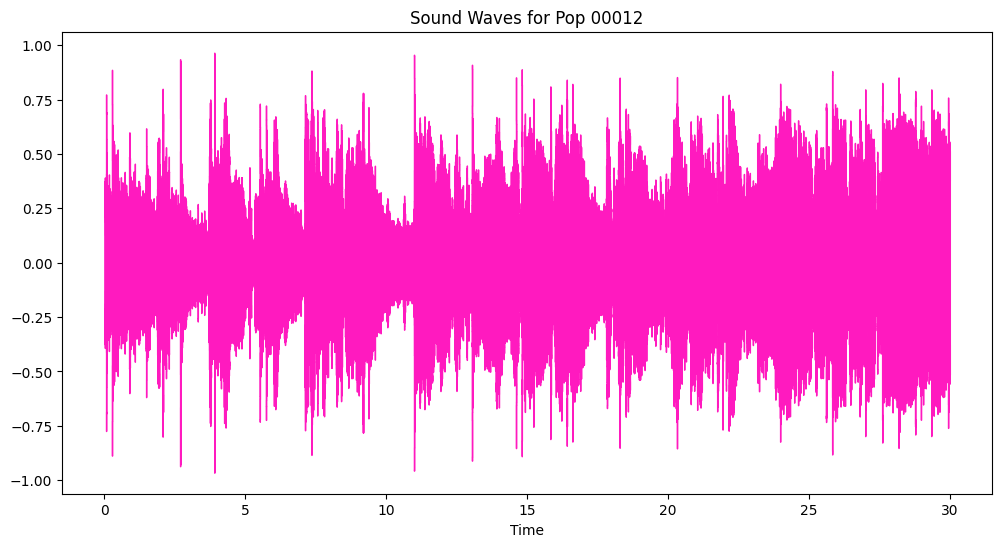

In [2]:
# displaying one of the pop genre audios
audio_file = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/pop/pop.00012.wav'
plt.figure(figsize=(12,6))
data, sample_rate = librosa.load(audio_file)
t_data, _ = librosa.effects.trim(data) # trimming potential leading/trailing silence

librosa.display.waveshow(t_data, sr=sample_rate, color="#FF1ABF")
plt.title("Sound Waves for Pop 00012", fontsize=12)
ipd.Audio(audio_file)

In [3]:
print("Audio File Data: ", t_data)
print("Sample Rate: ", sample_rate)

Audio File Data:  [ 0.16629028  0.19113159  0.19692993 ... -0.2711792  -0.40167236
 -0.372406  ]
Sample Rate:  22050


Above, we can see a visual representation of the sound waves for the Pop 00012 audio file, as well as play the audio. Using librosa, we have also gained the audio's normalized set of data and its sample rate. Some useful aspects of the librosa package are that, as mentioned, it normalizes the data for us, and it also takes the sample rate of any audio file and tries to convert it to 22050 Hz. The sample rate is the number of samples taken per second of a particular audio. A higher sample rate indicates better quality audio.[[6]](https://www.adobe.com/uk/creativecloud/video/discover/audio-sampling.html)

Text(0.5, 1.0, 'Fourier Transform on Pop 00012')

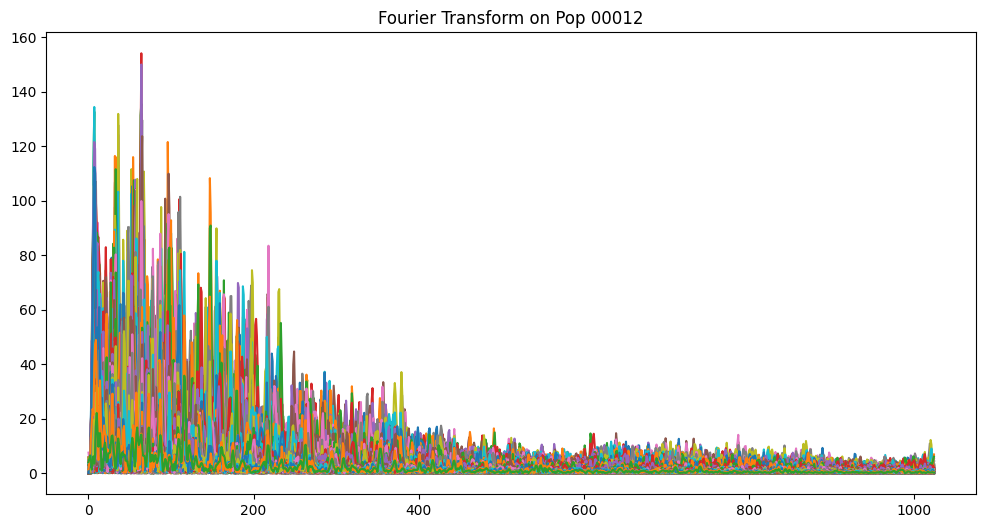

In [4]:
# Fourier Transform, looking at frequencies
n_fft = 2048
hop_length = 512
decomp = np.abs(librosa.stft(t_data, n_fft=n_fft, hop_length=hop_length))

plt.figure(figsize=(12, 6))
plt.plot(decomp)
plt.title("Fourier Transform on Pop 00012", fontsize=12)

The fourier transform is important because it allows us to analyze waves in a frequency domain. All waveforms are a sum of simple sinusoids of different frequencies, and the fourier transform provides us with the decomposition of a waveform into its sinusoidal components.[[7]](https://www.thefouriertransform.com/#introduction)

Text(0.5, 1.0, 'Spectrogram of Pop 00012')

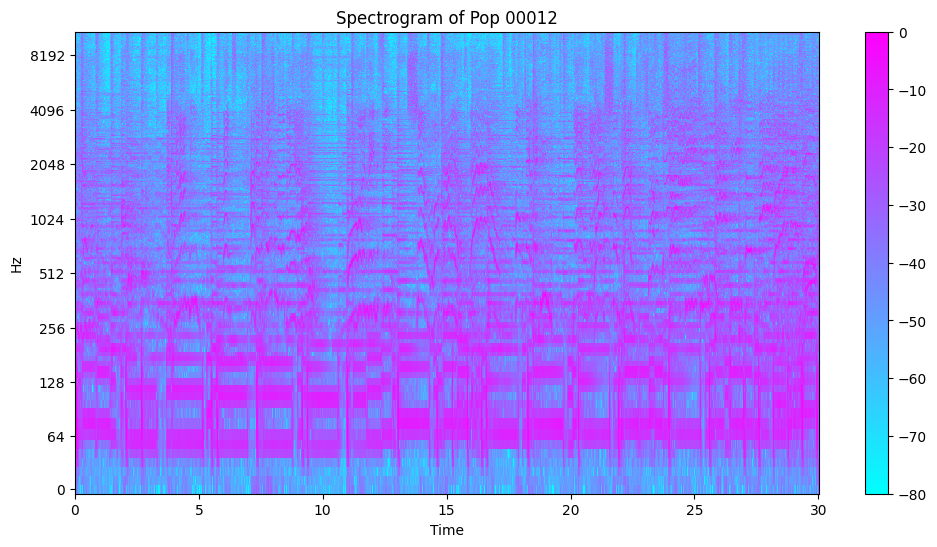

In [5]:
# Spectrogram, looking at frequencies over time
db_spec = librosa.amplitude_to_db(decomp, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(db_spec, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram of Pop 00012", fontsize=12)

A spectrogram provides us with a spectrum of an audio's frequencies over time. This is where some previously discussed features (such as spectral centroid) can be analyzed.

Text(0.5, 1.0, 'Chromagram of Pop 00012')

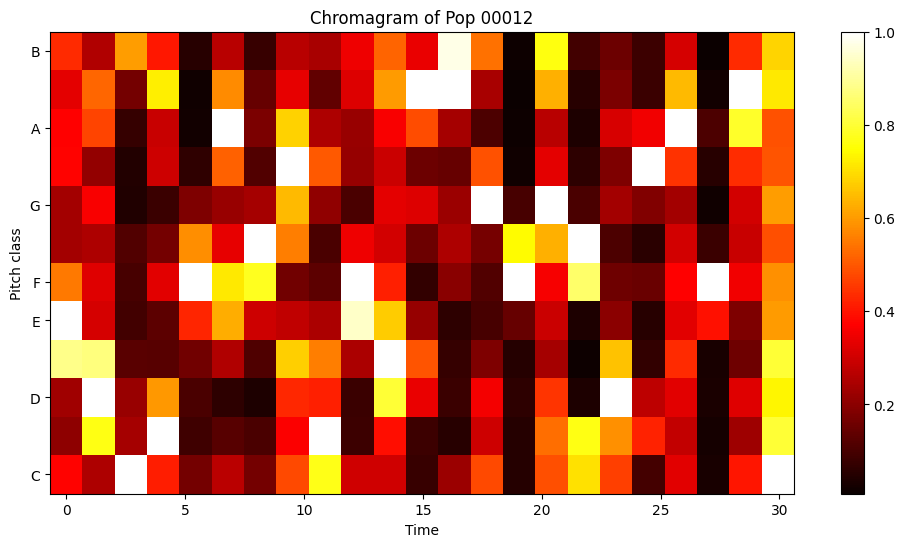

In [6]:
# Chromagram, looking at chroma intensity over time
chromagram = librosa.feature.chroma_stft(y=data, sr=sample_rate, hop_length=30000)

plt.figure(figsize=(12, 6))
librosa.display.specshow(chromagram, sr=sample_rate, hop_length=30000, x_axis='time', y_axis='chroma', cmap='hot');
plt.colorbar();
plt.title("Chromagram of Pop 00012", fontsize=12)

Text(0.5, 1.0, 'Mel Spectrogram of Pop 00012')

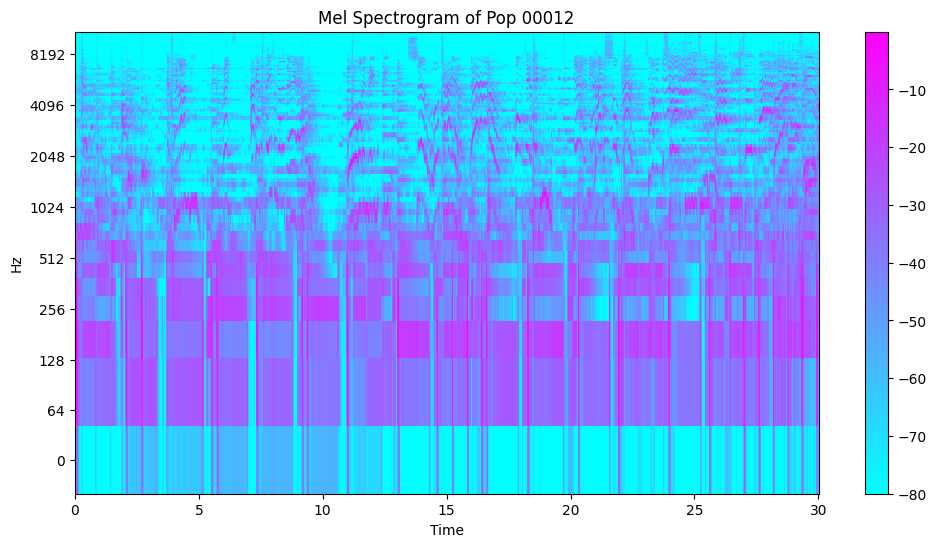

In [7]:
# Mel Spectrogram, looking at Mel frequencies over time
mel_S = librosa.feature.melspectrogram(y=data, sr=sample_rate)
mel_db = librosa.amplitude_to_db(mel_S, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(mel_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool');
plt.colorbar();
plt.title("Mel Spectrogram of Pop 00012", fontsize=12)

This Mel spectrogram shows us Mel frequencies over time. This is useful as the Mel Scale provides human-hearing based context.

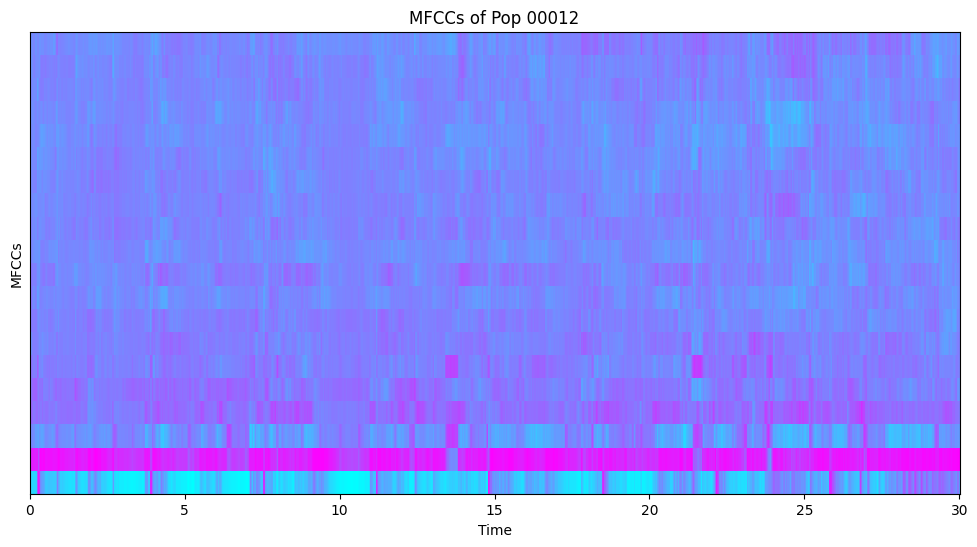

In [8]:
# Displaying MFCCs
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate)
mfccs = sklearn.preprocessing.StandardScaler().fit_transform(mfccs)

plt.figure(figsize=(12, 6))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap='cool');
plt.ylabel("MFCCs");
plt.title("MFCCs of Pop 00012", fontsize=12);

As discussed earlier, MFCCs are a crucial feature in analyzing audio data. Above is a visual representation (spectrogram) of MFCCs for an audio file.

**We will now do analysis of the GTZAN dataset's features** using a heatmap and a boxplot. The heatmap will show us correlations between features (we can see which are closely related), and the boxplot will provide us with an understanding of how our data is spread out for each label.

In [9]:
# reading csv
ds_path = "gtzan-dataset-music-genre-classification/Data/genres_original"
ds = pd.read_csv("/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv")
ds.head(10)

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
5  blues.00000.5.wav   66149          0.376670         0.089702  0.132618   
6  blues.00000.6.wav   66149          0.379909         0.088827  0.130335   
7  blues.00000.7.wav   66149          0.331880         0.092119  0.140600   
8  blues.00000.8.wav   66149          0.347877         0.094209  0.133130   
9  blues.00000.9.wav   66149          0.358061         0.082957  0.115312   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   
5  0.003583             1994.915219          211700.619569   
6  0.003166             1962.150096          177443.070045   
7  0.002546             1701.890924           35678.130616   
8  0.002538             1746.473502          138073.931244   
9  0.001846             1763.948942           61493.423121   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   
5              2152.767854            74263.873102  ...   31.448069   
6              2146.503479            98020.541422  ...   33.954071   
7              1979.387612            36670.725886  ...   38.456211   
8              1887.619723           117069.920049  ...   44.311455   
9              1874.195710            51944.921435  ...   43.967834   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   
5    -3.448373   34.284130    -0.416165   40.791092    -3.649625   32.457901   
6    -2.068194   25.623655     1.428141   47.957699    -3.267124   39.382240   
7    -3.637886   24.530296    -0.105148   26.716150    -2.016985   23.150423   
8    -4.370029   29.873167     2.114592   33.843155    -2.264663   80.812393   
9    -3.448304   48.671944     0.099792   41.839546    -7.677177   96.253654   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  
5     3.025218   28.892687  blues  
6     3.276939   25.999132  blues  
7     0.210787   42.512966  blues  
8     3.758598   97.618835  blues  
9     0.791776   40.416420  blues  

[10 rows x 60 columns]

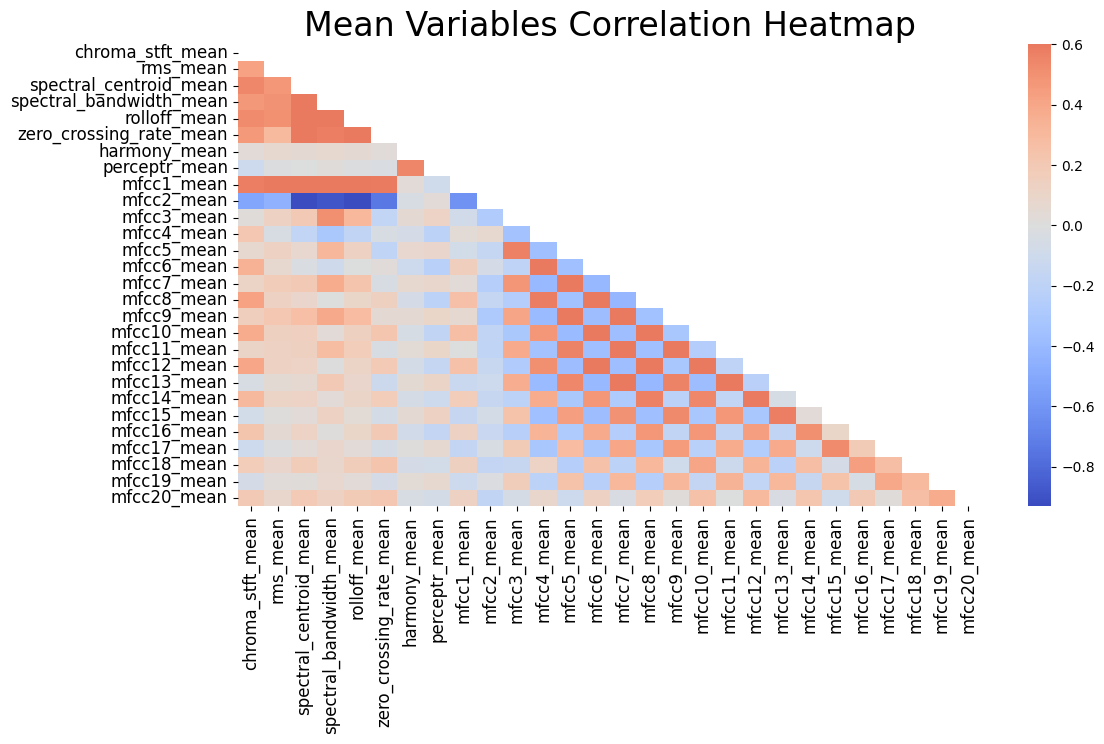

In [10]:
# mean variables correlation heatmap
cols = [col for col in ds.columns if 'mean' in col]
corr = ds[cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6));
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.6, center=0)
plt.title("Mean Variables Correlation Heatmap", fontsize=24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

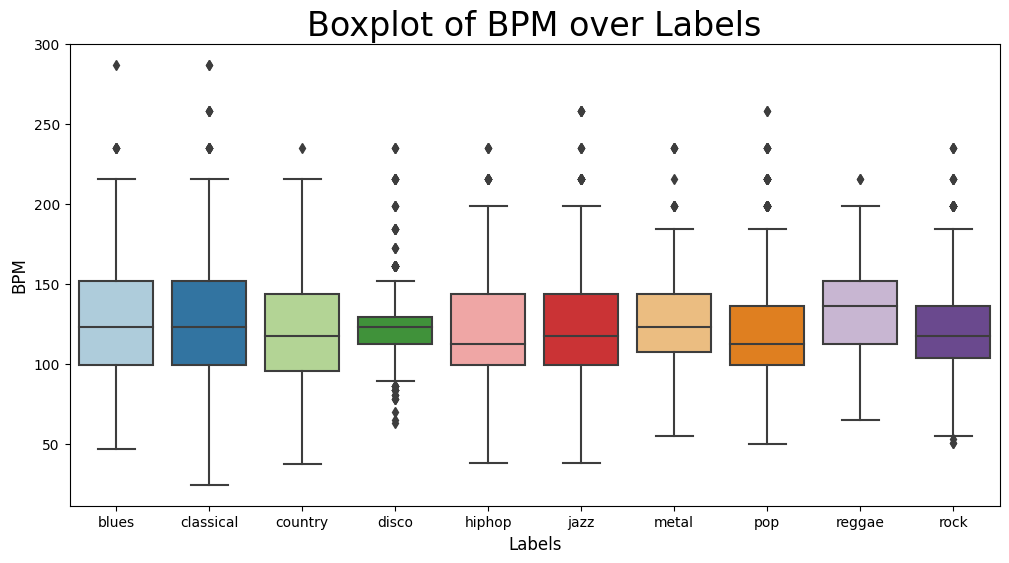

In [11]:
# BPM over labels boxplot
plot_data = ds[["label", "tempo"]]

plt.figure(figsize=(12, 6))
sns.boxplot(x="label", y="tempo", data=plot_data, palette='Paired')
plt.title("Boxplot of BPM over Labels", fontsize=24)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("BPM", fontsize=12);

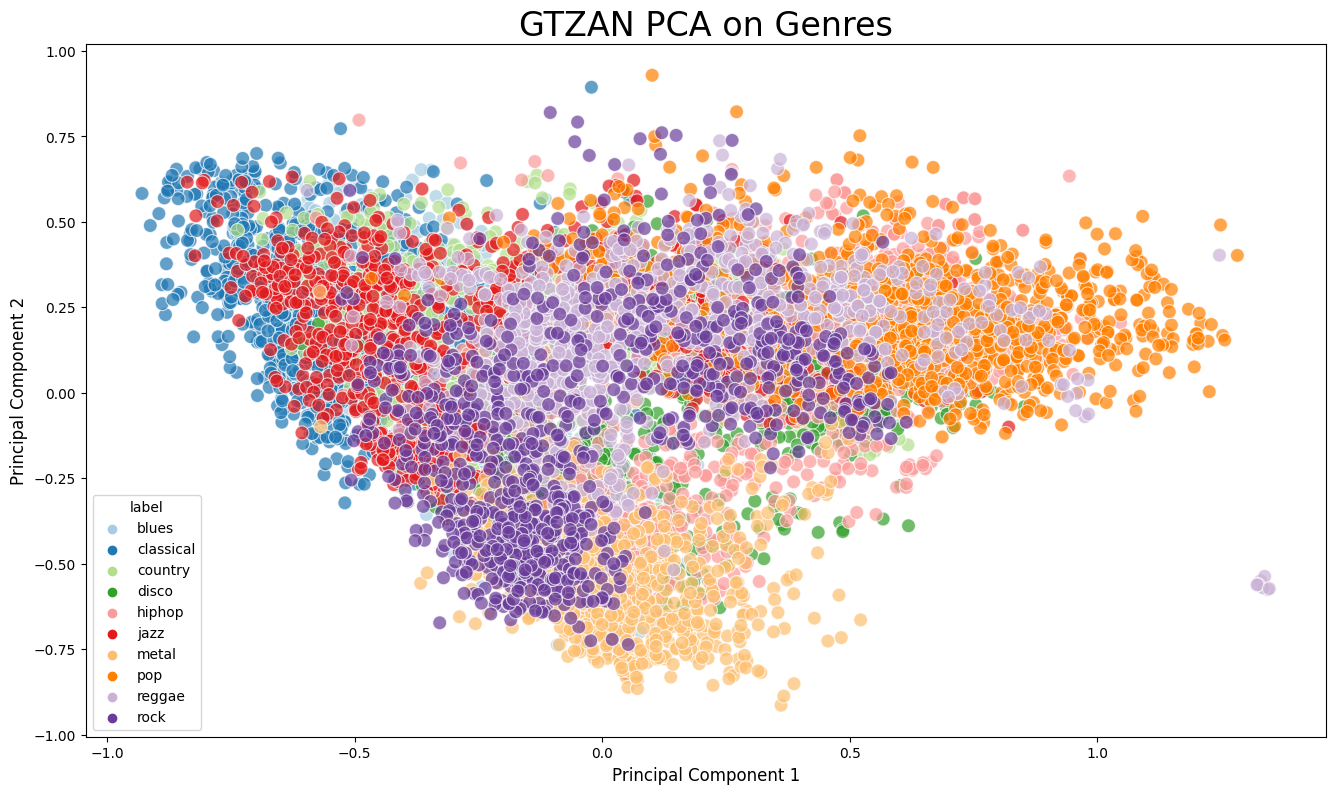

In [12]:
ds = ds.iloc[0:,1:]
y = ds['label']
X = ds.loc[:,ds.columns!='label']
columns = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns=columns)

# encoding labels
indices = dict()
for i, label in enumerate(ds.label.unique()):
    indices[label] = i
ds.label = [indices[i] for i in ds.label]

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

finalDf = pd.concat([principalDf, y], axis=1)
plt.figure(figsize=(16, 9))
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue="label", palette='Paired', alpha=0.7, s=100);

plt.title("GTZAN PCA on Genres", fontsize=24)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.savefig("PCA Scattert.jpg")

# Implementation of ANN and XGBoost
Through EDA there is a good sense of what audio data looks like as well as the distribution of data across the ten labels, so implementation of a music classier can now be looked at. 
A music classifier can be implemented using many different methods in machine learning. The two methods this project will focus on is the use of an Artificial Neural Network (ANN) and XGBoost. Along with implementation, the loss curves for each model will be plotted and the accuracy for each will also be recorded. This will allow comparison on the performance of the two models, as well as provide a decision for which model is best suited to music genre classification.

In [13]:
ds_shuffle = ds.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
y = ds_shuffle.pop('label')
X = ds_shuffle

trainX, testValX, trainY, testValY = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
devX, testX, devY, testY = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
ds.head(10)

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   
5   66149          0.376670         0.089702  0.132618  0.003583   
6   66149          0.379909         0.088827  0.130335  0.003166   
7   66149          0.331880         0.092119  0.140600  0.002546   
8   66149          0.347877         0.094209  0.133130  0.002538   
9   66149          0.358061         0.082957  0.115312  0.001846   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   
5             1994.915219          211700.619569              2152.767854   
6             1962.150096          177443.070045              2146.503479   
7             1701.890924           35678.130616              1979.387612   
8             1746.473502          138073.931244              1887.619723   
9             1763.948942           61493.423121              1874.195710   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   
5            74263.873102   4371.985614  ...   31.448069    -3.448373   
6            98020.541422   4325.026668  ...   33.954071    -2.068194   
7            36670.725886   3625.280386  ...   38.456211    -3.637886   
8           117069.920049   3586.934721  ...   44.311455    -4.370029   
9            51944.921435   3505.522649  ...   43.967834    -3.448304   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   
5   34.284130    -0.416165   40.791092    -3.649625   32.457901     3.025218   
6   25.623655     1.428141   47.957699    -3.267124   39.382240     3.276939   
7   24.530296    -0.105148   26.716150    -2.016985   23.150423     0.210787   
8   29.873167     2.114592   33.843155    -2.264663   80.812393     3.758598   
9   48.671944     0.099792   41.839546    -7.677177   96.253654     0.791776   

   mfcc20_var  label  
0   43.771767      0  
1   59.943081      0  
2   33.105122      0  
3   32.023678      0  
4   29.146694      0  
5   28.892687      0  
6   25.999132      0  
7   42.512966      0  
8   97.618835      0  
9   40.416420      0  

[10 rows x 59 columns]

In [15]:
scale = preprocessing.StandardScaler()
trainX = pd.DataFrame(scale.fit_transform(trainX), columns=trainX.columns)
devX = pd.DataFrame(scale.transform(devX), columns=trainX.columns)
testX = pd.DataFrame(scale.transform(testX), columns=trainX.columns)

In [16]:
ANN_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(trainX.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(10, activation='softmax'),
])

In [17]:
def train_ANN(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(trainX, trainY, validation_data=(devX, devY), epochs=epochs, batch_size=batch_size)

In [18]:
ANN_model_training = train_ANN(ANN_model, epochs=100, optimizer='adam')

Epoch 1/100
55/55 [==============================] - 3s 26ms/step - loss: 1.8160 - accuracy: 0.3335 - val_loss: 1.2031 - val_accuracy: 0.5903
Epoch 2/100
55/55 [==============================] - 1s 22ms/step - loss: 1.3154 - accuracy: 0.5330 - val_loss: 0.9018 - val_accuracy: 0.6969
Epoch 3/100
55/55 [==============================] - 1s 20ms/step - loss: 1.0733 - accuracy: 0.6441 - val_loss: 0.7632 - val_accuracy: 0.7466
Epoch 4/100
55/55 [==============================] - 1s 21ms/step - loss: 0.9153 - accuracy: 0.7018 - val_loss: 0.6165 - val_accuracy: 0.7980
Epoch 5/100
55/55 [==============================] - 1s 21ms/step - loss: 0.7972 - accuracy: 0.7456 - val_loss: 0.4915 - val_accuracy: 0.8397
Epoch 6/100
55/55 [==============================] - 1s 20ms/step - loss: 0.7042 - accuracy: 0.7723 - val_loss: 0.4389 - val_accuracy: 0.8614
Epoch 7/100
55/55 [==============================] - 1s 20ms/step - loss: 0.6238 - accuracy: 0.8027 - val_loss: 0.3746 - val_accuracy: 0.8809
Epoch 

In [19]:
ANN_test_loss, ANN_test_accuracy = ANN_model.evaluate(testX, testY, verbose=1)

print(f"Test Loss: {ANN_test_loss}")
print(f"Test Accuracy: {ANN_test_accuracy}")

125/125 [==============================] - 0s 3ms/step - loss: 0.2727 - accuracy: 0.9379
Test Loss: 0.2727352976799011
Test Accuracy: 0.9379379153251648


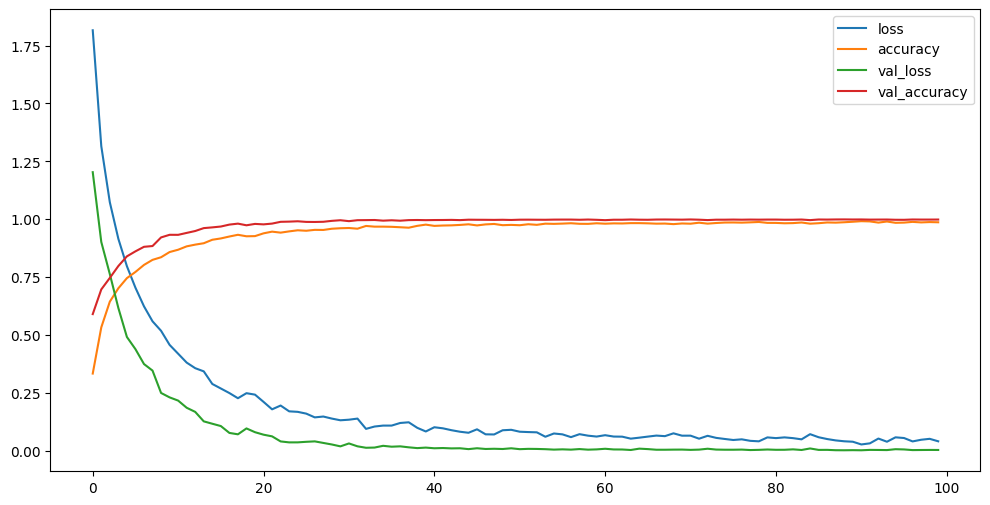

In [20]:
pd.DataFrame(ANN_model_training.history).plot(figsize=(12,6))
plt.show()

In [21]:
XGBoost = XGBClassifier(n_estimators=2000, learning_rate=0.05)
XGBoost.fit(trainX,trainY, eval_set=[(devX, devY)])

[0]	validation_0-mlogloss:2.17689
[1]	validation_0-mlogloss:2.07007
[2]	validation_0-mlogloss:1.97481
[3]	validation_0-mlogloss:1.88885
[4]	validation_0-mlogloss:1.81254
[5]	validation_0-mlogloss:1.74363
[6]	validation_0-mlogloss:1.67912
[7]	validation_0-mlogloss:1.62074
[8]	validation_0-mlogloss:1.56680
[9]	validation_0-mlogloss:1.51555
[10]	validation_0-mlogloss:1.46731
[11]	validation_0-mlogloss:1.42210
[12]	validation_0-mlogloss:1.37794
[13]	validation_0-mlogloss:1.33725
[14]	validation_0-mlogloss:1.29787
[15]	validation_0-mlogloss:1.26134
[16]	validation_0-mlogloss:1.22480
[17]	validation_0-mlogloss:1.19034
[18]	validation_0-mlogloss:1.15793
[19]	validation_0-mlogloss:1.12609
[20]	validation_0-mlogloss:1.09607
[21]	validation_0-mlogloss:1.06763
[22]	validation_0-mlogloss:1.03957
[23]	validation_0-mlogloss:1.01315
[24]	validation_0-mlogloss:0.98794
[25]	validation_0-mlogloss:0.96353
[26]	validation_0-mlogloss:0.94013
[27]	validation_0-mlogloss:0.91652
[28]	validation_0-mlogloss:0.8

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
testY_pred = XGBoost.predict(testX)
sklearn.metrics.accuracy_score(testY, testY_pred)

0.9241741741741741

# Sources
\[1\]: https://musicinformationretrieval.com/spectral_features.html#:~:text=Spectral%20rolloff%20is%20the%20frequency,%2C%20e.g.%2085%25%2C%20lies.

\[2\]: https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8

\[3\]: https://www.sciencedirect.com/topics/engineering/zero-crossing-rate

\[4\]: https://ee.columbia.edu/~dpwe/resources/matlab/chroma-ansyn/

\[5\]: https://www.ibm.com/topics/exploratory-data-analysis

\[6\]: https://www.adobe.com/uk/creativecloud/video/discover/audio-sampling.html

\[7\]: https://www.thefouriertransform.com/#introduction

\[Figure 1\]: http://tghsl3physics.weebly.com/standing-waves.html